# Transfer Learning with DenseNet121 on CIFAR-10

This notebook uses the **DenseNet121** model for transfer learning on the **CIFAR-10** dataset.

The key changes are:
1.  Loading the CIFAR-10 dataset directly from `tensorflow.keras.datasets`.
2.  Adding an `UpSampling2D` layer to resize the 32x32 CIFAR-10 images to 224x224, which DenseNet expects.
3.  Applying the `densenet.preprocess_input` function *inside* the model, after upsampling.
4.  Using `ImageDataGenerator.flow()` to feed the NumPy arrays (from CIFAR-10) to the model.

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

## 2. Load and Prepare CIFAR-10 Dataset

We load the data from `keras.datasets` and one-hot encode the labels.

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

NUM_CLASSES = 10

# One-hot encode the labels
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 10)


## 3. Setup Data Generators

We use `ImageDataGenerator` for data augmentation. Note that we do **not** use `preprocessing_function` or `rescale` here, as the preprocessing will be part of the model itself.

We use the `.flow()` method since we are feeding data from NumPy arrays.

In [3]:
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# For validation data, we only augment. No preprocessing needed here.
validation_datagen = ImageDataGenerator()

# Create the generators
train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size=BATCH_SIZE
)

validation_generator = validation_datagen.flow(
    x_test,
    y_test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

## 4. Build the Model

We create a new model that chains the following:
1.  `Input` layer for 32x32x3 images.
2.  `UpSampling2D` layer to scale images to 224x224.
3.  `preprocess_input` (as a layer) to apply DenseNet's normalization.
4.  The frozen `DenseNet121` base model.
5.  A new custom classifier head.

In [4]:
IMG_SHAPE = (32, 32, 3)
DENSENET_SHAPE = (224, 224, 3)

# Load the DenseNet121 base model, pre-trained on ImageNet
# We set the input_shape to what DenseNet expects (224x224)
base_model = DenseNet121(weights='imagenet',
                          include_top=False,
                          input_shape=DENSENET_SHAPE)

# Freeze the base model layers
base_model.trainable = False

# Create the new model on top
inputs = Input(shape=IMG_SHAPE)

# Upsample the 32x32 images to 224x224 (32 * 7 = 224)
x = UpSampling2D(size=(7, 7))(inputs)

# Apply DenseNet's specific preprocessing
x = preprocess_input(x)

# Pass the preprocessed, upsampled images to the base model
x = base_model(x, training=False) # Set training=False for a frozen model

# Add the custom classifier
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add (Add)                       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,097,354 (30.89 MB)

 Trainable params: 1,059,850 (4.04 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

## 5. Train the Model

Now we can train the model. We must specify `steps_per_epoch` and `validation_steps` because the generators are created from NumPy arrays.

In [5]:
EPOCHS = 10

steps_per_epoch = len(x_train) // BATCH_SIZE
validation_steps = len(x_test) // BATCH_SIZE

print("Starting training...")
print(f"Steps per Epoch: {steps_per_epoch}")
print(f"Validation Steps: {validation_steps}")

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

print("Training complete.")

Starting training...
Steps per Epoch: 1562
Validation Steps: 312
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 187s 101ms/step - accuracy: 0.4491 - loss: 1.5398 - val_accuracy: 0.6188 - val_loss: 1.0640
Epoch 2/10
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 1:49 70ms/step - accuracy: 0.7500 - loss: 0.8352

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.7500 - loss: 0.8352 - val_accuracy: 0.6141 - val_loss: 1.0812
Epoch 3/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 133s 85ms/step - accuracy: 0.5549 - loss: 1.2433 - val_accuracy: 0.6339 - val_loss: 0.9996
Epoch 4/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.5000 - loss: 1.4482 - val_accuracy: 0.6341 - val_loss: 0.9969
Epoch 5/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 142s 91ms/step - accuracy: 0.5741 - loss: 1.1894 - val_accuracy: 0.6522 - val_loss: 1.0076
Epoch 6/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.4688 - loss: 1.3515 - val_accuracy: 0.6489 - val_loss: 1.0247
Epoch 7/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 132s 85ms/step - accuracy: 0.5879 - loss: 1.1585 - val_accuracy: 0.6818 - val_loss: 0.9142
Epoch 8/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.6562 - loss: 1.0712 - val_accuracy: 0.6811 - val_loss: 0.9127
Epoch 9/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 132s 84ms/step - accuracy: 0.5933 - loss: 

## 6. (Optional) Plot Training History

After training, you can visualize the model's accuracy and loss over time.

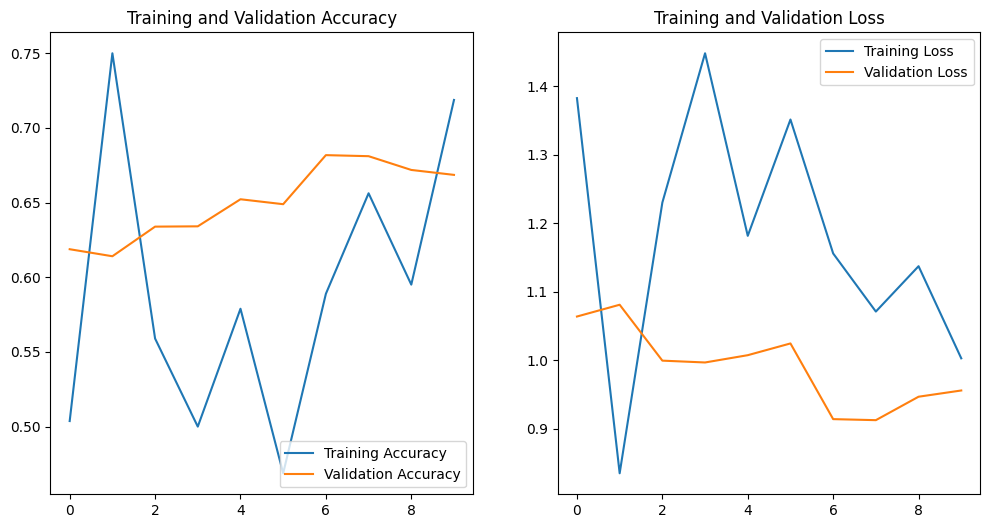

In [6]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc)) # Use len(acc) in case training stops early

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()